# Libraries

In [1]:
import torch, os
from torchvision import datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
sys.path.append('..')
from models import VAE

# Initialize model & dataloader

In [2]:
# Model

model = VAE(in_dims=784, hid_dims=100)
model.load_state_dict(torch.load('checkpoints/vae.pth', map_location='cpu')['state_dict'])
model.eval();

In [3]:
# Dataloader

data_dir = "/media/antiaegis/storing/datasets/"
os.makedirs(data_dir, exist_ok=True)
dataset = datasets.MNIST(data_dir, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
]))

# Encode and reconstruct images

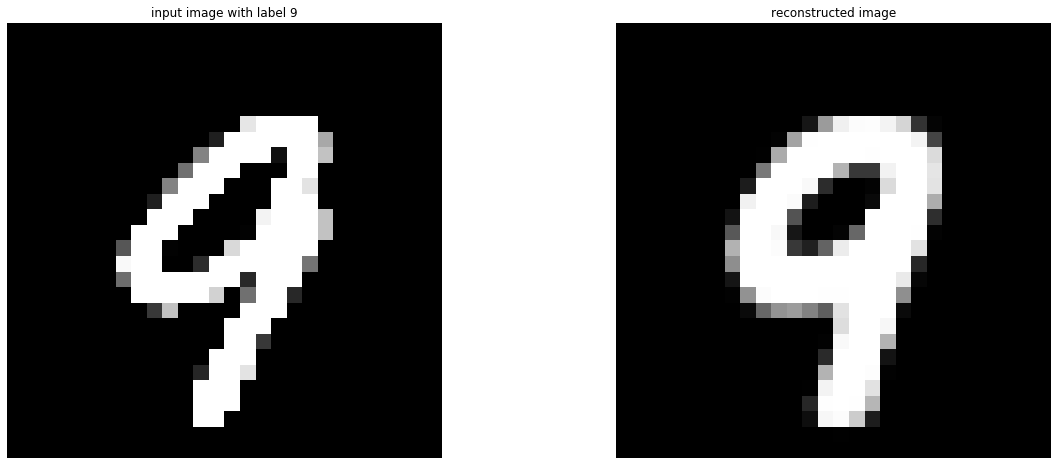

In [4]:
idx = np.random.randint(0, len(dataset.targets), ())
image, label = dataset.__getitem__(idx)
input = image.view(1,-1)

output = model(input)
recons_img = output.view(28, 28).detach().cpu().numpy()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1); plt.imshow(image.cpu().numpy()[0,...], vmin=0.0, vmax=1.0, cmap='gray'); plt.axis('off'); plt.title('input image with label %d'%(label))
plt.subplot(1,2,2); plt.imshow(recons_img, vmin=0.0, vmax=1.0, cmap='gray'); plt.axis('off'); plt.title('reconstructed image')
plt.show()

# Generate images

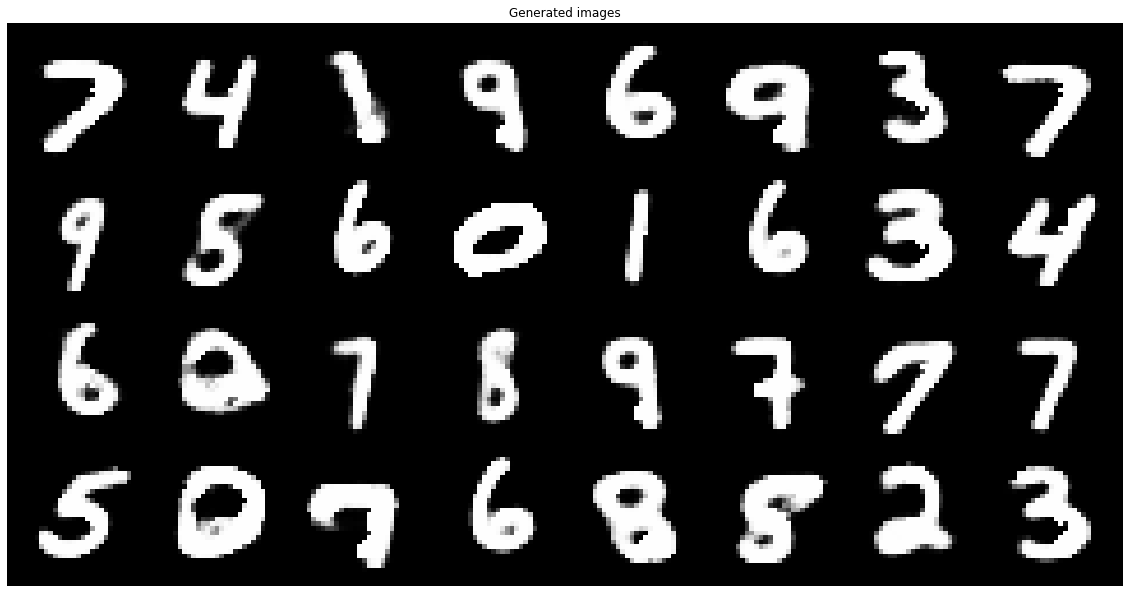

In [5]:
with torch.no_grad():
    inputs = torch.cat([torch.randn([1, 100]) for i in range(32)], dim=0)
    outputs = model.decoder(inputs)
    outputs = outputs.view(-1, 1, 28, 28)
    grid_img = make_grid(outputs.data, nrow=8, normalize=True).cpu().numpy().transpose((1,2,0))

plt.figure(figsize=(20,20))
plt.imshow(grid_img)
plt.axis('off')
plt.title("Generated images")
plt.show()

# Analysize hidden representations of classes

In [6]:
zero = np.zeros([100], np.float32)
hiddens = {0:zero.copy(), 1:zero.copy(), 2:zero.copy(), 3:zero.copy(), 4:zero.copy(), 5:zero.copy(), 6:zero.copy(), 7:zero.copy(), 8:zero.copy(), 9:zero.copy()}
counts = [0]*10

with torch.no_grad():
    for idx in tqdm(range(len(dataset.targets)), total=len(dataset.targets)):
        image, label = dataset.__getitem__(idx)
        input = image.view(1,-1)
        z = model.represent(input).view(100).numpy()
        hiddens[label] += z
        counts[label] += 1

100%|██████████| 10000/10000 [00:03<00:00, 2544.64it/s]


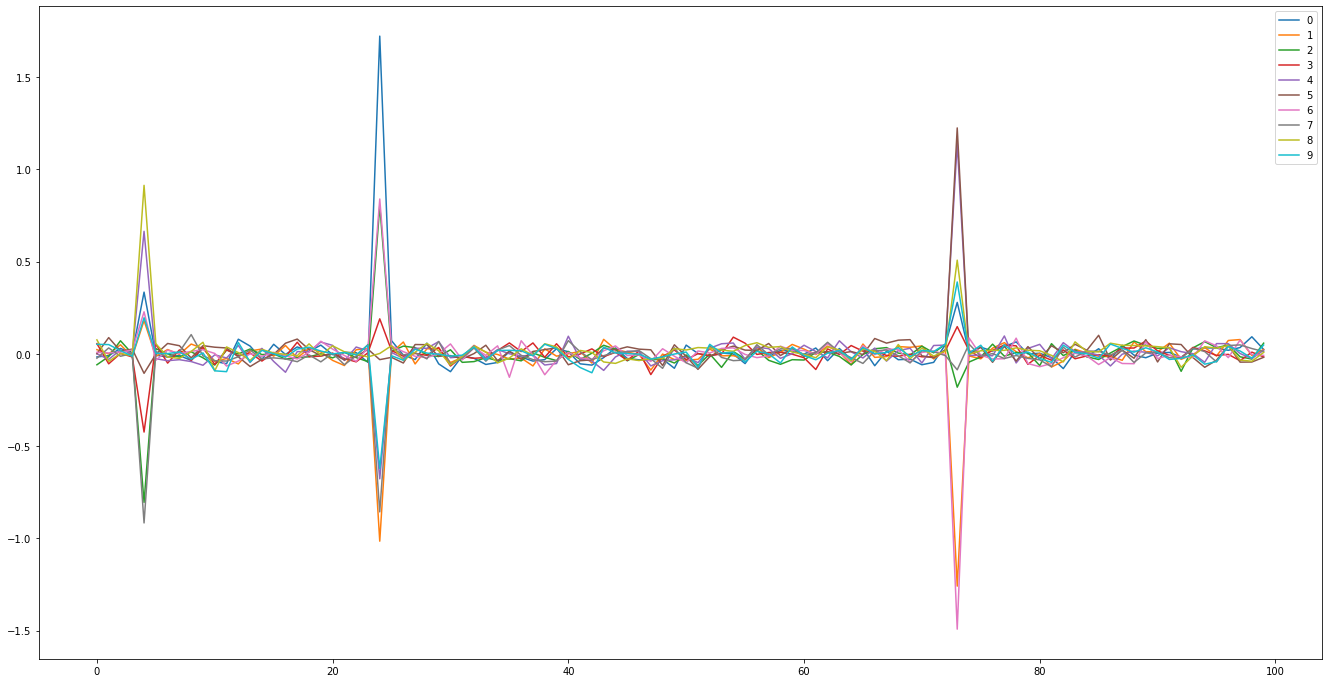

In [7]:
for i in range(10):
    hiddens[i] /= counts[i]

plt.figure(figsize=(23,12))
for i in range(10):
    plt.plot(hiddens[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()